In this project, we will build a movie recommendation system using content-based filtering. We will use the [MovieLens dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset), provided in Kaggle, which contains movie and user data, to recommend movies to an user based on the genres of movies he has liked the most.

## Content-based filtering overview

The idea of content-based filtering is simple.

1. represent items with a set of features
2. discover a users preferences to each of those features, based on items they have already rated/consumed/liked
3. infer the users preference to unseen items based on those item features.

Unlike more sophisticated recommendation systems, such as collaborative filtering, content-based filtering only uses data provided by a single user to model their preferences. Thus it is much simpler to implement.

### A concrete example

In our project, we will build a movie recommendation system, so let's use that as an example. We begin with a list of ratings a user has given to the movies they have watched:

| Movie ID | Movie Title  | User Rating |
| -------- | ------------ | ----------- |
| 1        | Inception    | 5.0         |
| 2        | The Matrix   | 4.5         |
| 3        | Interstellar | 4.0         |

Each of the movies belongs to a list of genres:

| Movie ID | Movie Title  | Genres           |
| -------- | ------------ | ---------------- |
| 1        | Inception    | Sci-Fi, Thriller |
| 2        | The Matrix   | Sci-Fi, Action   |
| 3        | Interstellar | Sci-Fi, Drama    |

If we average the ratings the user has given for each movie _by genre_, we get the user's ratings for each genre.

- Sci-Fi appears in all three movies, so its average rating is:
  $$ \frac{(5.0 + 4.5 + 4.0)}{3} = 4.5 $$
- Thriller appears only in _Inception_, so its average rating is: **5.0**
- Action appears only in _The Matrix_, so its average rating is: **4.5**
- Drama appears only in _Interstellar_, so its average rating is: **4.0**

This gives us a single user's ratings by genre.

| Genre    | Average Rating |
| -------- | -------------- |
| Sci-Fi   | 4.5            |
| Thriller | 5.0            |
| Action   | 4.5            |
| Drama    | 4.0            |

Now, let's consider a new list of movies that user has not yet watched.

| Movie ID | Movie Title        | Genres           |
| -------- | ------------------ | ---------------- |
| 4        | Blade Runner 2049  | Sci-Fi, Thriller |
| 5        | Mad Max: Fury Road | Action, Sci-Fi   |
| 6        | The Social Network | Drama            |

To estimate the ratings for these unseen, we take the **average of the user's ratings for the movie's genres**:

- **Blade Runner 2049 (Sci-Fi, Thriller)**  
  $$ \frac{(4.5 + 5.0)}{2} = 4.75 $$
- **Mad Max: Fury Road (Action, Sci-Fi)**  
  $$ \frac{(4.5 + 4.5)}{2} = 4.5 $$
- **The Social Network (Drama)**
  - Drama’s average rating is **4.0**, so the estimated rating is **4.0**.

| Movie ID | Movie Title        | Inferred Rating |
| -------- | ------------------ | --------------- |
| 4        | Blade Runner 2049  | 4.75            |
| 5        | Mad Max: Fury Road | 4.5             |
| 6        | The Social Network | 4.0             |

Now we know that, if we were to recommend new movies for that user to watch, we would recommend "Blade Runner 2049 " first, then "Mad Max: Fury Road" and "The Social Network" last.

## Resources

The video below contains an overview of the method we will implement. However, unlike the example above, they use a method which gives more weight to genres a user has rated more movies in. We will fix that mistake and show the differences in both methods.

<iframe width="560" height="315" src="https://www.youtube.com/embed/YMZmLx-AUvY?si=jz2I8XVknb9X2Y3a" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## Downloading the dataset

As you have seen above, we need a dataset that contains:

1. movies with their genres
2. user ratings for movies

Fortunately, the MovieLens dataset has both of these pieces of data. We will download it using the [`kagglehub`](https://github.com/Kaggle/kagglehub) package.


In [58]:
import pathlib as pl

import kagglehub
import pandas as pd

(mvls_links_path, mvls_genometags_path, mvls_movies_path, mvls_genomescores_path, mvls_tags_path, mvls_ratings_path) = (
  list(pl.Path(kagglehub.dataset_download("grouplens/movielens-20m-dataset")).iterdir())
)
print(
  mvls_links_path, mvls_genometags_path, mvls_movies_path, mvls_genomescores_path, mvls_tags_path, mvls_ratings_path
)

/home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv


MovieLens contains a collection of CSV files. You can see below the movie-related data, which contains the movie and year of release in one column, and all of its genres on another.


In [59]:
movies = pd.read_csv(mvls_movies_path).set_index("movieId").sort_index()
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


The first thing we will do is represent movie genres by one-hot encoded columns. We will also keep a record of the names of these columns for later.


In [60]:
# get a single list of all unique genres for all movies
genres = list(set(movies["genres"].str.split("|").sum()))
genres = sorted(genres)
movies = movies.join(movies["genres"].str.get_dummies(sep="|")).drop("genres", axis=1)
display(genres)
movies.head()

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Regarding user ratings to movies, MovieLens provides us 20 million ratings. In the cell below, you can see a few basic characteristics of user ratings. Most importantly, they range from 0.5 to 5 in intervals of 0.5


In [61]:
ratings = pd.read_csv(mvls_ratings_path)
ratings["rating"].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

A user rating to a movie ties a user ID to a movie ID and contains the 0.5--5 rating the user has given the movie. In this project, we will work only with the user whose ID is 1. Let's peek at some movies he has seen and their ratings.

We can see that user 1 has watched and rated 175 movies. That is a lot of movies. Also, the minimum rating user 1 has given to a movie is 3, far from the 0.5 it is allowed to give.


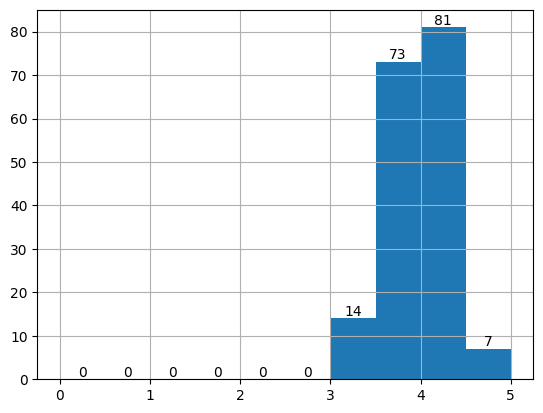

In [62]:
user_ratings = ratings[ratings["userId"] == 1]
ax = user_ratings["rating"].hist(bins=10, range=(0, 5))
ax.bar_label(ax.containers[0]);

This is what the user-movie rating data actually looks like.


In [63]:
user_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


## Computing user-genre preferences

Our goal now will be to generate the user's features, which will be derived from the genres of the movies they have watched and their ratings.

To make things easier for us, we will join user 1's movie ratings with the genres of those movies.


In [64]:
user_ratings = user_ratings[["userId", "movieId", "rating"]].merge(movies, on="movieId")
user_ratings.head()

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,47,3.5,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,3.5,"Usual Suspects, The (1995)",0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


Now, we will propagate the user's ratings to the genres of each movie. by multiplying the ratings user 1 has given to a movie with the genre columns of each movie. You will see that the one-hot encoding of that movie will become the actual ratings user 1 has given to the movie.


In [65]:
# multiply the genre columns by the rating
user_ratings[genres] = user_ratings[genres].multiply(user_ratings["rating"], axis="index")
user_ratings

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,Jumanji (1995),0.0,0.0,3.5,0.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.5,0.0,3.5,0.0,0.0,0.0
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.5,0.0,3.5,3.5,0.0,0.0
3,1,47,3.5,Seven (a.k.a. Se7en) (1995),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0
4,1,50,3.5,"Usual Suspects, The (1995)",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1,8507,5.0,Freaks (1932),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171,1,8636,4.5,Spider-Man 2 (2004),0.0,4.5,4.5,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,4.5,0.0,0.0,0.0
172,1,8690,3.5,Slaughterhouse-Five (1972),0.0,0.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,3.5,0.0
173,1,8961,4.0,"Incredibles, The (2004)",0.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, if we sum all the ratings user 1 has given to the movies they have watched _by genre_, we get a proxy value that denotes how much user 1 enjoys each of the genres.


In [66]:
user_genre_preferences = pd.DataFrame(
  data={"Movies": (user_ratings[genres] != 0).sum(), "Sum of ratings": user_ratings[genres].sum()}
)
user_genre_preferences.sort_values("Sum of ratings", ascending=False)

,Movies,Sum of ratings
Adventure,73,276.5
Fantasy,69,261.5
Action,66,246.0
Horror,45,168.5
Drama,43,162.0
Thriller,42,158.0
Comedy,41,153.0
Sci-Fi,40,148.5
Crime,21,80.0
Children,19,68.5


Because the magnitudes of these sums of ratings can get out of hand, we can divide them by the sum of all ratings and get neat values that all add up to 1.


In [67]:
user_genre_preferences["Normalized sum of ratings"] = (
  user_genre_preferences["Sum of ratings"] / user_genre_preferences["Sum of ratings"].max()
)
user_genre_preferences.sort_values("Normalized sum of ratings", ascending=False)

,Movies,Sum of ratings,Normalized sum of ratings
Adventure,73,276.5,1.000000
Fantasy,69,261.5,0.945750
Action,66,246.0,0.889693
Horror,45,168.5,0.609403
Drama,43,162.0,0.585895
Thriller,42,158.0,0.571429
Comedy,41,153.0,0.553345
Sci-Fi,40,148.5,0.537071
Crime,21,80.0,0.289331
Children,19,68.5,0.247740


These values are interesting and they may be used as an indication of how much a user prefers certain movie genres. This is the way that is taught in the video at the beginning of the page.

However, because this method just sums all ratings the user has given to a collection of movies, it favors those genres in which the user has given more ratings, regardless of how low the ratings are.

For example, if a user watches 9 action movies and gives a rating of 1 to all of them, the Action genre will have a weight of 9 in our preference vector:

```
1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 9
```

If that same user watches 2 musicals (I know, who likes musicals) but gives a rating of 4 to both of them, the Musical genre will have a weight of 8 in our fetaure vector, which is less than the weight of the Action genre.

```
4 + 4 = 8
```

But we can clearly see that this user hates action movies but loves musicals!

Our hypothesis is corroborated in the chart below, in which our sum of ratings for a genre grows as the user watches more movies.


<Axes: >

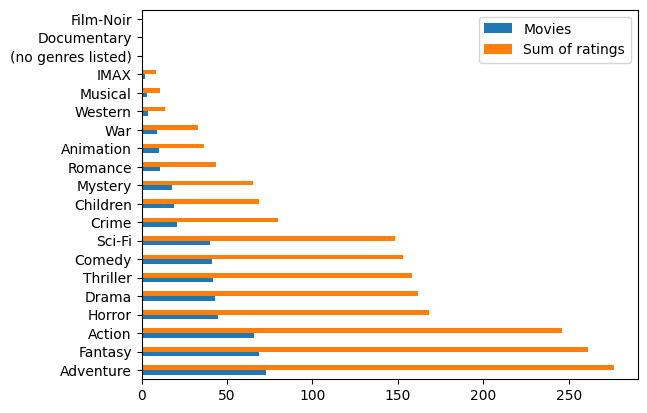

In [68]:
user_genre_preferences[["Movies", "Sum of ratings"]].sort_values("Movies", ascending=False).plot.barh()

By looking at the correlations between number of movies watched, sum of ratings and the normalized sum of ratings, we can see a pretty hgh positive correlation between all of them.


In [69]:
user_genre_preferences.corr()

,Movies,Sum of ratings,Normalized sum of ratings
Movies,1.000000,0.999871,0.999871
Sum of ratings,0.999871,1.000000,1.000000
Normalized sum of ratings,0.999871,1.000000,1.000000


One way we can mitigate this is by taking the _average_ of the ratings a user gives to the movies of a particular genre as their preference for that genre.


In [70]:
user_genre_preferences["Normalized by movies in genre"] = (
  user_genre_preferences["Sum of ratings"] / user_genre_preferences["Movies"]
)
user_genre_preferences = user_genre_preferences.sort_values("Normalized by movies in genre", ascending=False)
user_genre_preferences

,Movies,Sum of ratings,Normalized sum of ratings,Normalized by movies in genre
IMAX,2,8.5,0.030741,4.250000
Romance,11,43.5,0.157324,3.954545
Crime,21,80.0,0.289331,3.809524
Fantasy,69,261.5,0.945750,3.789855
Adventure,73,276.5,1.000000,3.787671
Drama,43,162.0,0.585895,3.767442
Thriller,42,158.0,0.571429,3.761905
Horror,45,168.5,0.609403,3.744444
Comedy,41,153.0,0.553345,3.731707
Action,66,246.0,0.889693,3.727273


If we now look at the correlation of the two feature sets implemented, we can see they are mostly uncorrelated, which means they are two completely different ways of expressing user preference.


In [71]:
user_genre_preferences[["Normalized sum of ratings", "Normalized by movies in genre"]].corr()

,Normalized sum of ratings,Normalized by movies in genre
Normalized sum of ratings,1.000000,0.050581
Normalized by movies in genre,0.050581,1.000000


As you can see above, the second choice of features is very interesting. While before, we thought that the user enjoyed the Adventure, Fantasy Action and Horror genres, now we belive they enjoy IMAX movies, romances and crimes, even though they have watched less movies in that genre.

## Inferring unseen movie preferences

Now that we know how much the user prefers each genre, we will compute the ratings for movies that user has not watched yet.

First, let's get all the movies they have not watched from MovieLens.


In [106]:
# get the movies that the user has not seen
unseen_movies = movies.loc[~movies.index.isin(user_ratings["movieId"])].copy()
unseen_movies

,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Heat (1995),0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,Kein Bund für's Leben (2007),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131258,The Pirates (2014),0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As an intermediate step, we will to propagate the user's genre preferences to the preferences of these unseen movies.


In [107]:
content_based_ratings = unseen_movies[genres].multiply(user_genre_preferences["Normalized by movies in genre"])
content_based_ratings

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,NaN,0.000000,3.787671,3.65,3.605263,3.731707,0.000000,NaN,0.000000,3.789855,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,NaN,0.000000,0.000000,0.00,0.000000,3.731707,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.0,0.0,0.0,3.954545,0.0,0.000000,0.0,0.0
4,NaN,0.000000,0.000000,0.00,0.000000,3.731707,0.000000,NaN,3.767442,0.000000,NaN,0.000000,0.0,0.0,0.0,3.954545,0.0,0.000000,0.0,0.0
5,NaN,0.000000,0.000000,0.00,0.000000,3.731707,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
6,NaN,3.727273,0.000000,0.00,0.000000,0.000000,3.809524,NaN,0.000000,0.000000,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,3.761905,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,NaN,0.000000,0.000000,0.00,0.000000,3.731707,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
131256,NaN,0.000000,0.000000,0.00,0.000000,3.731707,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
131258,NaN,0.000000,3.787671,0.00,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


We then sum these preferences _by movie_ and divide by the number of genres each movie has, to get the user preferences for each unseen movie.

If we sort the movies by these inferred preferences, we get a list in descending order of the movies user 1 has not seen but might enjoy, based on their genres and the ratings user 1 has given to the movies they have seen.


In [108]:
content_based_ratings = content_based_ratings.sum(axis=1) / (content_based_ratings != 0).sum(axis=1)
unseen_movies["content_based_rating"] = content_based_ratings
unseen_movies[["title", "content_based_rating"]].sort_values("content_based_rating", ascending=False)

,title,content_based_rating
movieId,,
81132,Rubber (2010),2.776340
76153,Lupin III: First Contact (Rupan Sansei: Faasut...,2.728501
75408,Lupin III: Sweet Lost Night (Rupan Sansei: Swe...,2.728501
5018,Motorama (1991),2.724701
26093,"Wonderful World of the Brothers Grimm, The (1962)",2.723014
...,...,...
32225,Project Grizzly (1996),0.000000
90693,"Sunday Day in Hell, A (En forårsdag i Helvede)...",0.000000
108493,"Fourth World War, The (2003)",0.000000


We can also compute the alternate user-genre preferences, using normalized sums of ratings, which are highly correlated with the number of movies watched in each genre. You can see we get a different list of movies, although some movies remain in the list and the first movie is the same.


In [109]:
content_based_ratings = unseen_movies[genres].multiply(user_genre_preferences["Normalized sum of ratings"])
content_based_ratings = content_based_ratings.sum(axis=1)
unseen_movies["content_based_rating2"] = content_based_ratings
unseen_movies[["title", "content_based_rating2"]].sort_values("content_based_rating2", ascending=False)

,title,content_based_rating2
movieId,,
81132,Rubber (2010),4.783002
49593,She (1965),4.725136
5018,Motorama (1991),4.717902
71999,Aelita: The Queen of Mars (Aelita) (1924),4.687161
72165,Cirque du Freak: The Vampire's Assistant (2009),4.569620
...,...,...
100246,Pretty Sweet (2012),0.000000
99,Heidi Fleiss: Hollywood Madam (1995),0.000000
100266,Day Is Done (2011),0.000000


One disadvantage of content-based filtering is that we cannot recommend items to a user whose features we have no data for that user. Because this user has watched over 100 movies, we are able to recommend over 90% of unseen movies to them.


In [ ]:
f"{(unseen_movies['content_based_rating'] != 0).sum() / len(unseen_movies):%}"

'91.875438%'

## Conclusion

In this project, we have built a movie recommendation system based on content-based filtering. We went through the theory of content-based filtering as well as an example, then used a publicly available dataset to implement the system. We compared two ways of building user features and saw one of the downsides of content-based filtering, which is the inability of recommending new items to a user if those items don't have intersecting features with the items the user has already rated.

See you guys next time!
